# 03 - Vertex AI > Pipelines - AutoML automated pipeline

Use[ Kubeflow](https://www.kubeflow.org/) Pipelines running on [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/introduction) to orchestrate the process of training a custom model with AutoML Tabular and deploy it to a Vertex AI Endpoint for serving (online and batch) predictions and explanations.  
### Prerequisites:
-  01 -  BigQuery - Table Data Source

### Resources:
-  [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/build-pipeline#google-cloud-components) see aiplatform.PipelineJob
-  [Python Client for Vertex AI](https://googleapis.dev/python/aiplatform/latest/aiplatform.html)
-  [Kubeflow Pipelines Components for Google Cloud](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud)

### Related Training:
-  Codelab: [Vertex AI Pipelines Introduction](https://codelabs.developers.google.com/vertex-mlmd-pipelines#0)


## Setup

inputs:

In [38]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'bootkon-2024'

In [39]:
REGION = 'us-central1'
# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'ml_datasets'
BQ_TABLE = 'ulb_fraud_detection'
NOTEBOOK = '03'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id Feedback service_account_email' # add more variables to the string with space delimiters

packages:

In [ ]:
#!pip install -U google-cloud-pipeline-components -U -q

In [40]:
from google.cloud import aiplatform
from datetime import datetime
import kfp
from kfp import compiler
#import kfp.v2.dsl as dsl
#import google_cloud_pipeline_components as gcc_aip
from google_cloud_pipeline_components.v1.dataset import TabularDatasetCreateOp
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [41]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client()

parameters:

In [42]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{BQ_TABLE}/models/{NOTEBOOK}"
DIR = f"temp/{NOTEBOOK}"

In [43]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'112412469323-compute@developer.gserviceaccount.com'

List the service accounts current roles:

In [44]:
!gcloud projects get-iam-policy $PROJECT_ID --filter="bindings.members:$SERVICE_ACCOUNT" --format='table(bindings.role)' --flatten="bindings[].members"

ROLE
roles/aiplatform.user
roles/bigquery.dataEditor
roles/bigquery.jobUser
roles/bigquery.readSessionUser
roles/dataproc.worker
roles/iam.serviceAccountUser
roles/ml.developer
roles/pubsub.admin
roles/resourcemanager.projectIamAdmin
roles/serviceusage.serviceUsageConsumer
roles/storage.admin
roles/storage.objectAdmin


>Note: If the resulting list is missing [roles/storage.objectAdmin](https://cloud.google.com/storage/docs/access-control/iam-roles) then [revisit the setup notebook](../00%20-%20Setup/00%20-%20Environment%20Setup.ipynb#permissions) and add this permission to the service account with the provided instructions.

environment:

In [45]:
!rm -rf {DIR}
!mkdir -p {DIR}

## Pipeline (KFP) Definition
- Flow
    - Create Vertex AI Dataset from link to BigQuery table
    - Create Vertex AI AutoML Tabular Training Job
    - Create Endpoint and Depoy trained model
    
Use [AI Platform Pipeline Components](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/)
- Specifically, [AutoMLTabularTrainingJobRunOp](https://google-cloud-pipeline-components.readthedocs.io/en/google-cloud-pipeline-components-0.2.0/google_cloud_pipeline_components.aiplatform.html#google_cloud_pipeline_components.aiplatform.AutoMLTabularTrainingJobRunOp)

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

In [46]:
@kfp.dsl.pipeline(
    name = f'kfp-{NOTEBOOK}-{BQ_TABLE}-{TIMESTAMP}',
    pipeline_root = URI+'/'+str(TIMESTAMP)+'/kfp/'
)
def pipeline(
    project: str,
    dataname: str,
    display_name: str,
    deploy_machine: str,
    bq_source: str,
    var_target: str,
    var_omit: str,
    features: dict,
    labels: dict 
):
    
    # dataset
    dataset = TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source,
        labels = labels
    )
    
    # training
    model = AutoMLTabularTrainingJobRunOp(
        project = project,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = "maximize-au-prc",
        budget_milli_node_hours = 1000,
        disable_early_stopping=False,
        column_specs = features,
        dataset = dataset.outputs['dataset'],
        target_column = var_target,
        predefined_split_column_name = 'splits',
        labels = labels
    )
    
    # Endpoint: Creation
    endpoint = EndpointCreateOp(
        project = project,
        display_name = display_name,
        labels = labels
    )
    
    # Endpoint: Deployment of Model
    deployment = ModelDeployOp(
        model = model.outputs["model"],
        endpoint = endpoint.outputs["endpoint"],
        dedicated_resources_min_replica_count = 1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type= deploy_machine
    )

---
## Compile Pipeline

In [47]:
compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = f"{DIR}/{NOTEBOOK}.json"
)

Move compiled pipeline files to GCS Bucket

In [48]:
!gsutil cp {DIR}/{NOTEBOOK}.json {URI}/{TIMESTAMP}/kfp/

Copying file://temp/03/03.json [Content-Type=application/json]...
/ [1 files][ 46.6 KiB/ 46.6 KiB]                                                
Operation completed over 1 objects/46.6 KiB.                                     


---
## Create Vertex AI Pipeline Job

Get features dictionary for the pipeline input:

In [49]:
# get feature names
query = f"SELECT * FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = '{BQ_TABLE}_prepped'"
schema = bq.query(query).to_dataframe()
OMIT = VAR_OMIT.split() + [VAR_TARGET, 'splits']
features = schema[~schema.column_name.isin(OMIT)].column_name.tolist()
features = dict.fromkeys(features, 'auto')

query


"SELECT * FROM bootkon-2024.ml_datasets.INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'ulb_fraud_detection_prepped'"

Run The pipeline:

In [55]:
pipeline = aiplatform.PipelineJob(
    display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    template_path = f"{URI}/{TIMESTAMP}/kfp/{NOTEBOOK}.json",
    parameter_values = {
        "project" : PROJECT_ID,
        "dataname" : BQ_TABLE,
        "display_name" : f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
        "deploy_machine" : DEPLOY_COMPUTE,
        "bq_source" : f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
        "var_target" : VAR_TARGET,
        "var_omit" : VAR_OMIT,
        "features" : features,
        "labels" : {'notebook': NOTEBOOK}       
    },
    labels = {'notebook': NOTEBOOK},
    enable_caching=False
)

In [56]:
# this job would take +2 hours,  depending on your infrastcuture
response = pipeline.run(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/112412469323/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/112412469323/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423?project=112412469323
PipelineJob projects/112412469323/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/112412469323/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/112412469323/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detecti

## For the rest of the commands, because the pipeline job takes signifiant time, we will show the results of the following commands on stage.

Visual Representation of the pipeline can be viewed in the colsole:

In [57]:
print(f"Review the Pipeline as it runs here:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/pipelines/runs/{pipeline.resource_name.split('/')[-1]}?project={PROJECT_ID}")

Review the Pipeline as it runs here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423?project=bootkon-2024


In [63]:
print(pipeline)
print(f'kfp-{NOTEBOOK}-{BQ_TABLE}-{TIMESTAMP}')

resource name: projects/112412469323/locations/us-central1/pipelineJobs/kfp-03-ulb-fraud-detection-20240417063335-20240417064423
kfp-03-ulb_fraud_detection-20240417063335


---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.

Get the Model:

In [65]:
models = aiplatform.Model.list(filter=f'labels.notebook={NOTEBOOK}')

In [66]:
model = models[0]
model.resource_name

'projects/112412469323/locations/us-central1/models/5928391874619375616'

Retrives the aggregate model evalution metrics for the model as a whole.  

Either:
- First, use `model.list_model_evaluations()` to retrieve the evaluation id, then use `model.get_model_evaluation(evaluation_id = )` for the evaluation id
- Or, use `.get_model_evaluation()` and it will retrieve the first model evaluation

In [67]:
evaluation = model.get_model_evaluation().to_dict() # get first evaluation

In [68]:
evaluation.keys()

dict_keys(['name', 'metricsSchemaUri', 'metrics', 'createTime', 'sliceDimensions', 'modelExplanation'])

In [69]:
evaluation['metrics'].keys()

dict_keys(['auPrc', 'auRoc', 'logLoss', 'confusionMatrix', 'confidenceMetrics'])

In [70]:
evaluation['metrics']['auPrc']

0.9999767

In [71]:
evaluation['metrics']['confidenceMetrics'][3]

{'falseNegativeCount': '1',
 'recallAt1': 0.9998233,
 'falsePositiveRateAt1': 0.00017671904,
 'truePositiveCount': '56586',
 'recall': 0.99998236,
 'trueNegativeCount': '56432',
 'confidenceThreshold': 0.01,
 'falsePositiveRate': 0.002739145,
 'precisionAt1': 0.9998233,
 'confusionMatrix': {'rows': [[56525.0, 2.0, 0.0],
   [8.0, 52.0, 0.0],
   [0.0, 0.0, 0.0]],
  'annotationSpecs': [{'displayName': '0', 'id': '0'},
   {'displayName': '1', 'id': '1'},
   {'displayName': 'DROPPED', 'id': 'DROPPED'}]},
 'precision': 0.99726826,
 'f1ScoreAt1': 0.9998233,
 'f1ScoreMacro': 0.766734,
 'f1Score': 0.9986235,
 'falsePositiveCount': '155',
 'f1ScoreMicro': 0.9986235}

Review several of the metrics included in the evaluation.  Also, compare these to the results in the console view.

In [72]:
print(f"Review this model in the console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{model.name}/versions/{model.version_id}/evaluations/{evaluation['name'].split('/')[-1]}?project={PROJECT_ID}")

Review this model in the console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/5928391874619375616/versions/1/evaluations/5371110969792833852?project=bootkon-2024


In [73]:
evaluation['metrics']['auPrc']

0.9999767

In [74]:
for i in range(len(evaluation['metrics']['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', evaluation['metrics']['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', evaluation['metrics']['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [56525.0, 2.0, 0.0]
True Label =  1  has Predicted labels =  [8.0, 52.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model as well using the .gapic api version:

In [76]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [77]:
slices = model_client.list_model_evaluation_slices(parent = evaluation['name'])

In [78]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  1 has auPrc =  0.9653369
Label =  0 has auPrc =  0.99998224


---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [79]:
pred = bq.query(
    query = f"""
        SELECT * EXCEPT({VAR_TARGET}, splits, transaction_id, Feedback)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped
        WHERE splits='TEST'
        LIMIT 10
    """
).to_dataframe()

In [80]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,service_account_email
0,140317.0,2.108409,0.134713,-1.958079,0.267756,0.744460,-0.448830,0.160228,-0.173553,0.529731,...,-0.398122,-1.030431,0.271110,-0.121153,-0.191452,0.214235,-0.060176,-0.037058,1.98,112412469323-compute@developer.gserviceaccount...
1,133768.0,2.021321,-0.348230,-1.042850,0.586625,-0.402463,-1.004997,-0.065193,-0.213470,1.072862,...,0.054380,0.378115,0.069959,0.091295,0.043567,0.638116,-0.071060,-0.067976,16.00,112412469323-compute@developer.gserviceaccount...
2,18552.0,-0.265284,0.081207,1.595559,-1.671107,-0.359368,-0.158713,-0.188054,0.271057,2.710338,...,0.102560,0.673973,0.126516,-0.065758,-1.159539,-1.066871,0.283226,0.230268,11.85,112412469323-compute@developer.gserviceaccount...
3,152499.0,0.068814,0.975844,-0.333363,-0.632815,0.966233,-0.492556,0.889090,0.036201,-0.364427,...,-0.268589,-0.652442,0.115306,0.608932,-0.469374,0.091150,0.221669,0.076151,8.08,112412469323-compute@developer.gserviceaccount...


In [81]:
import pandas as pd
pred['Time'] = pd.to_numeric(pred['Time'], errors='coerce')


# Now convert your DataFrame to a dictionary
newobs = pred.to_dict(orient='records')

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [82]:
# Parse the dictionary to the format expected by the model for prediction
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]
#instances

### Get Predictions: Python Client

In [83]:
aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')

 resource name: projects/112412469323/locations/us-central1/endpoints/4997911467916263424,
 resource name: projects/112412469323/locations/us-central1/endpoints/8744906357888516096,
 resource name: projects/112412469323/locations/us-central1/endpoints/8073870013410312192]

In [84]:
# Proceed with getting the endpoint and making a prediction
endpoint = aiplatform.Endpoint.list(filter=f'labels.notebook={NOTEBOOK}')[0]
endpoint.display_name

'03_ulb_fraud_detection_20240417063335'

In [85]:
prediction = endpoint.predict(instances = instances) # or instances = newobs
#prediction
prediction.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9999891519546509, 1.078314380720258e-05]}

In [86]:
prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

'0'

### Get Predictions: REST

In [87]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newobs[0]]}))

In [88]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{REGION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99998915195465088,
        1.0783141988213171e-05
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "589230480348413952",
  "model": "projects/112412469323/locations/us-central1/models/5928391874619375616",
  "modelDisplayName": "03_ulb_fraud_detection_20240417063335",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [89]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={REGION} --json-request={DIR}/request.json

Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9999891519546509, 1.078314198821317e-05]}]


## Explanations
Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

In [90]:
explanation = endpoint.explain(instances = instances)

In [91]:
explanation.predictions[0]

{'classes': ['0', '1'], 'scores': [0.9999891519546509, 1.078314380720258e-05]}

In [92]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.9523953199386597
instance output 0.9999891519546509
output_index [0]
output display value 0
approximation error 0.012997637635939176


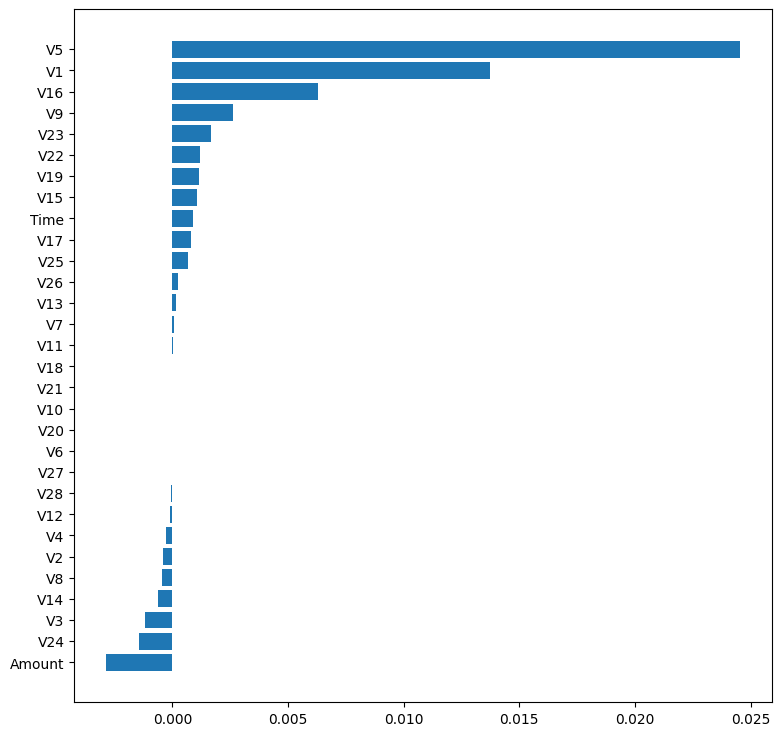

In [93]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations

In [ ]:
# this job would take +2 hours,  depending on your infrastcuture
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{BQ_TABLE}_{TIMESTAMP}',
    model_name = endpoint.list_models()[0].model,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation=True,
    labels = {'notebook':f'{NOTEBOOK}'}
)